# Merge of IGN and Bugianen, Mont-blanc area

This file is identical to `merge_frit3` except with `fritN=4`  and this description :-)

* French side: IGNt4 ie a specific area downloaded from geoportail
* Italian side: Bugianen 2205 - roughly Susa, Lanzo, Gran paradiso
  (all merged, check `maki-Sorbetto-merge.ipynb`)

Steps overview
* Cut Bugianen_merged to the same latitudes as the IGN side
* z14/z15/16 - merge along border
* z13: clean & merge it < fr
* z<12: add IGN basemap as Bugianen has nothing



In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from os.path import exists, join as pjoin, realpath
NBROOT = realpath(os.curdir)

import logging
logging.basicConfig(level=logging.DEBUG)
logging.getLogger('PIL').level = logging.INFO # PIL.PngImagePlugin

import sys
sys.path.append(realpath('..'))
sys.path.append(realpath('../../eslope/development/src'))

import json
from pathlib import Path
from time import time
from urllib.error import HTTPError
from urllib.request import urlopen, urlretrieve
from subprocess import check_call, CalledProcessError

try:
    # like os.system but with live output
    from IPython.utils.process import system
    def check_run(cmd):  # type:ignore
        r = system(cmd)
        if r: raise CalledProcessError(r, cmd)
        return r
except ImportError:
    def check_run(cmd):
        return check_call(cmd, shell=True)

#external
#!pip install shapely
import shapely
from shapely.geometry import mapping, shape, GeometryCollection, Polygon, Point
from shapely.ops import cascaded_union
import numpy as np
from IPython.display import display, Image
from PIL import Image as Img
import mercantile as T
from osgeo import gdal
gdal.UseExceptions()

# own
import mbt_util as M
import bbox
from mbt_util import mbt_merge, mbt_info
from src import img_util as G, geometry as GY, \
    mbt_download as MD, mbt_partial as MP, mbt_pyramid as MY, swisstopo as SS
from src.jpg_quality_pil_magick import get_jpg_quality


In [4]:
mbtnames_fr = {
    1: 'IGNt1-Mercantour-Ubaye-Antibes-Embrun.mbtiles',  # 1.3GB
    # Préalpes, Trois-Evéchés, Pelat, Mercantour-Argentera, Parpaillon, Chambeyron
    2: 'IGNt2-Digne-Aups-Eguilles-Gap.mbtiles',  # 1.3 GB
    # Préalpes de Digne, Lubéron, Vaucluse, Baronnies, Bochaine, Diois-S
    3: 'IGNt3-Vercors-Ecrins-Cerces.mbtiles',  # 1.2
    # Vercors, Taillefer, Dévoluy, Ecrins, Cerces, Queyras, Escreins
    # coupé en 2 t3/t4: Grandes Rousses, Arves, Cerces
    4: 'IGNt4-Chartreuse-Vanoise Chambery-Bardon.mbtiles',  # 1 GB
    # Chartreuse, Belledonne, Grandes Rousses N, Arves N, Cerces N, Lauzière, Vanoise, Mont-Cenis
    5: 'IGNt5-MontBlanc-Chambery-Evian.mbtiles'  # 1.1 GB
    # Bauges, Beaufortain, Bornes, Aravis, Mont-Blanc, Aiguilles Rouges, Giffre, Chablais
}
mbtnames_merged = GY.bbalp_names

In [5]:
# This could be useful to restrict the area to merge to speed it up
border_zones = {
    4: dict(west=6.62, east=7.19),
    3: dict(west= 6.64, east=7.08),
    1: dict(west=6.85, east=7.72)  # instead of 8.174 for bug
}

In [6]:
fritN = 4
workdir = f'frit{fritN}/'
os.makedirs(workdir, exist_ok=True)

orig = pjoin(realpath('../../mapdata/mobac_atlases'), mbtnames_fr[fritN])
mbtfr = pjoin(workdir, f'fr{fritN}.mbtiles')
!ln -sf "$orig" "$mbtfr"
M.mbt_info(mbtfr)

'zoom = 9 16 ; n = 49153 * 20 kb/tile ; bounds = 5.625,45.089,7.732,45.583 ; format = jpg ; name = IGNt4-Chartreuse-Vanoise Chambery-Bardon'

In [7]:
finalname = mbtnames_merged[fritN]
finalpath = pjoin(workdir, finalname + '.mbtiles')

In [39]:
# this map contains z9-11 of enlarged Metropolitan France (-5 42.3 8.6 51.1)
mbtwalpsz9 = pjoin(realpath('../../mapdata/mobac_atlases'), 'IGN-fr-z9-12.mbtiles')
#also 'IGN-walps-z9-10.mbtiles'
M.mbt_info(mbtwalpsz9)

'zoom = 9 12 ; n = 27429 ; bounds = -5.625,42.035,9.138,51.179 ; format = jpg'

In [41]:
mbtitall = '../../mapdata/mbtiles/Bugianen.mbtiles'
M.mbt_info(mbtitall)

'zoom = 12 16 ; n = 152742 ; bounds = 6.5918,45.08904,7.91016,45.58329 ; center = 7.25098,45.33616,12 ; format = jpg'

In [26]:
bbfr = M.real_bounds(mbtfr)
bballit = M.real_bounds(mbtitall)
print("bbfr", bbfr)
# bbitcut = bbfr._replace(east=bballit.east)
bbitcut = GY.bbalps[fritN]

print("bbcutit", bbitcut)
mbtitcut = workdir + "itcutN.mbtiles"
! rm -f $mbtitcut
M.cut_to_lnglat(mbtitall, mbtitcut, bbitcut) #, zmin=14)

# it's tricky to not get extra tiles, see `epsilon` in cut_to_lng_lat

bbfr LngLatBbox(west=5.625000000000014, south=45.08903556483102, east=7.73437500000001, north=45.583289756006316)
bbcutit LngLatBbox(west=5.625000000000014, south=45.08903556483102, east=7.91, north=45.583289756006316)
12 16 16
12 2123 <> 2137 2624 <> 2631
z 12 : 76
13 4246 <> 4275 5248 <> 5263
z 13 : 304
14 8492 <> 8551 10496 <> 10527
z 14 : 1216
15 16984 <> 17103 20992 <> 21055
z 15 : 4864
16 33968 <> 34207 41984 <> 42111
z 16 : 19430
real bounds: LngLatBbox(west=6.591796874999988, south=45.08903556483102, east=7.9101562500000036, north=45.583289756006316)


In [42]:
bbfrit = bbfr._replace(east=M.real_bounds(mbtitcut).east)
bbfrit

LngLatBbox(west=5.625000000000014, south=45.08903556483102, east=7.9101562500000036, north=45.583289756006316)

In [44]:
# fill up the gaps at lower zoom levels

mbtbasemap = pjoin(workdir, 'basemap.mbtiles')
!rm $mbtbasemap
M.cut_to_lnglat(mbtwalpsz9, mbtbasemap, bbfrit)
mbtbasemapclean, reasons = MP.clean_missing_data(mbtbasemap, w=0.1, T=192)
reasons

9 12 12
9 264 <> 267 328 <> 328
z 9 : 4
10 528 <> 534 656 <> 657
z 10 : 14
11 1056 <> 1068 1312 <> 1315
z 11 : 52
12 2112 <> 2137 2624 <> 2631
z 12 : 208
real bounds: LngLatBbox(west=5.625000000000014, south=45.08903556483102, east=8.43749999999999, north=45.583289756006316)


In [49]:
#!gpxsee $mbtbasemap


QSocketNotifier: Can only be used with threads started with QThread
/home/me/.local/share/gpxsee/DEM/N46E004.hgt: No such file or directory
/home/me/.local/share/gpxsee/DEM/N46E005.hgt: No such file or directory
/home/me/.local/share/gpxsee/DEM/N45E005.hgt: No such file or directory
/home/me/.local/share/gpxsee/DEM/N45E006.hgt: No such file or directory
/home/me/.local/share/gpxsee/DEM/N45E008.hgt: No such file or directory
/home/me/.local/share/gpxsee/DEM/N46E008.hgt: No such file or directory


In [ ]:
#!gpxsee $mbtitcut


/home/me/.local/share/gpxsee/DEM/N45E006.hgt: No such file or directory
QObject::disconnect: No such signal GUI::logicalDotsPerInchChanged(qreal)


## Common to all zoom levels

Attempt to remove white tiles
becuse IGN tiles can have a lot of white esp. in flat areas (Geneva) we raise the requirement of partial tile to 30% white and 192 contiguous white pixels (75% of a side)

In [17]:
mbtfrclean, stats = MP.clean_missing_data(mbtfr, w=0.1, T=255)
mbtfrclean, stats

Deleted 0. Status: 0 / 49153
Deleted 11. Status: 2000 / 49153
Deleted 26. Status: 4000 / 49153
Deleted 0. Status: 6000 / 49153
Deleted 0. Status: 8000 / 49153
Deleted 14. Status: 10000 / 49153
Deleted 217. Status: 12000 / 49153
Deleted 208. Status: 14000 / 49153
Deleted 2. Status: 16000 / 49153
Deleted 1. Status: 18000 / 49153
Deleted 2. Status: 20000 / 49153
Deleted 7. Status: 22000 / 49153
Deleted 0. Status: 24000 / 49153
Deleted 0. Status: 26000 / 49153
Deleted 3. Status: 28000 / 49153
Deleted 0. Status: 30000 / 49153
Deleted 0. Status: 32000 / 49153
Deleted 0. Status: 34000 / 49153
Deleted 0. Status: 36000 / 49153
Deleted 0. Status: 38000 / 49153
Deleted 55. Status: 40000 / 49153
Deleted 97. Status: 42000 / 49153
Deleted 79. Status: 44000 / 49153
Deleted 113. Status: 46000 / 49153
Deleted 539. Status: 48000 / 49153
Deleted 807. Status: done!


('frit4/clean_1673708435fr4.mbtiles',
 defaultdict(int,
             {'': 46972,
              'partial': 377,
              'white': 1790,
              'black&white': 13,
              'black': 1}))

In [129]:
!mv $mbtfrclean $workdir/ignt4clean.mbtiles
mbtfrclean = pjoin(workdir, 'ignt4clean.mbtiles')

In [74]:
# let's have a quick look at a "dumb" merge as it's much quicker
M.mbt_merge(mbtbasemap, mbtitcut, mbtfrclean, dest=pjoin(workdir, 'tmp.mbtiles'), name="1st try")

In [51]:
print(M.real_bounds(pjoin(workdir, 'tmp.mbtiles'), log=print))

real bounds  9 [5.63, 45.09, 8.44, 45.58]
real bounds  10 [5.63, 45.09, 8.09, 45.58]
real bounds  11 [5.63, 45.09, 7.21, 45.58]
real bounds  12 [5.63, 45.03, 7.91, 45.58]
real bounds  13 [5.63, 45.06, 7.91, 45.58]
real bounds  14 [5.63, 45.07, 7.91, 45.58]
real bounds  15 [5.63, 45.08, 7.91, 45.58]
real bounds  16 [5.63, 45.09, 7.91, 45.58]
LngLatBbox(west=5.625000000000014, south=45.02695045318546, east=8.43749999999999, north=45.583289756006316)


In [ ]:
# This could be useful to restrict the area to merge to speed it up
border_zone = bbfr._replace(*border_zones[fritN])

## Geometry!

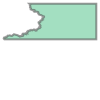

In [75]:
# cut french side from the italian bbox
it_to_keep = GY.bb2poly(bbfrit).difference(GY.frch)
it_to_keep

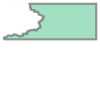

In [76]:

it_to_keep14 = it_to_keep.buffer(0.0006)
GY.sh2geojson(it_to_keep14, pjoin(workdir, 'it_to_keep14.geojson'))
it_to_keep14

In [31]:

it_to_keep15 = it_to_keep.buffer(0.0003)
GY.sh2geojson(it_to_keep15, pjoin(workdir, 'it_to_keep15.geojson'))

## Merge at z14/15/16

In [37]:
def runc(cmd):
    start = time()
    print(cmd)
    check_run(cmd)
    print(f'{time()-start:.1f} seconds')

In [38]:

z_to_process = (14, 15, 16)
optmulti = '-multi -wo NUM_THREADS=ALL_CPUS'

for zlevel in z_to_process:
    # generate vrt italian side
    k = min(zlevel, 15)
    vrt = f"{workdir}/it{zlevel}.vrt"
    runc(f'''gdalwarp -cutline {workdir}/it_to_keep{k}.geojson -crop_to_cutline \
        {mbtitcut} -oo ZOOM_LEVEL={zlevel} {vrt} -overwrite''')

    # apply on top of france, in 2 steps to work around issue gdal#7067
    mrg = f"{workdir}/mrg{zlevel}"
    runc(f'''gdalwarp {mbtfrclean} -oo ZOOM_LEVEL={zlevel} {vrt} {mrg}.tif -co TILED=yes -overwrite {optmulti}''')
    runc(f'''gdal_translate {mrg}.tif {mrg}.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=99''')

# for z16, ~20 minutes for the warp + 8 for the translate ; creates an intermediate 14 GB file :-|

gdalwarp -cutline frit4//it_to_keep14.geojson -crop_to_cutline         -oo ZOOM_LEVEL=14 frit4/itcutN.mbtiles frit4//it14.vrt -overwrite
Using band 4 of source image as alpha.
Creating output file that is 14965P x 8210L.
Processing frit4/itcutN.mbtiles [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdalwarp frit4/ignt4clean.mbtiles -oo ZOOM_LEVEL=14 frit4//it14.vrt frit4//mrg14.tif -co TILED=yes -overwrite
Warning 6: driver VRT does not support open option ZOOM_LEVEL
Creating output file that is 26629P x 8210L.
Using band 4 of destination image as alpha.
Processing frit4/ignt4clean.mbtiles [1/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing frit4//it14.vrt [2/2] : 0Using band 4 of source image as alpha.
...10...20...30...40...50...60...70...80...90...100 - done.
gdal_translate frit4//mrg14.tif frit4//mrg14.mbtiles -co TILE_FORMAT=JPEG -co QUALITY=99
Input file size is 26629, 8210
0...10...20...30..

In [ ]:
# !rm $finalpath

mbt_merge(
    mbtitcut,
    mbtfrclean,
    pjoin(workdir, 'mrg14.mbtiles'),
    pjoin(workdir, 'mrg15.mbtiles'),
    pjoin(workdir, 'mrg16.mbtiles'),
    mbtbasemap,  # overrides z12 of mbtit
    dest=finalpath,
    name=finalname,
)

In [ ]:
M.real_bounds(finalpath, log=print)

real bounds  9 [5.63, 45.09, 8.44, 45.58] 264 328 267 328
real bounds  10 [5.63, 45.09, 8.09, 45.58] 528 656 534 657
real bounds  11 [5.63, 45.09, 7.91, 45.58] 1056 1312 1068 1315
real bounds  12 [5.63, 44.02, 8.79, 46.5] 2112 2607 2147 2646
real bounds  13 [5.63, 44.02, 8.79, 46.5] 4224 5214 4295 5293
real bounds  14 [5.63, 44.02, 8.79, 46.5] 8448 10428 8591 10587
real bounds  15 [5.63, 44.02, 8.79, 46.5] 16896 20856 17183 21175
real bounds  16 [5.63, 44.02, 8.79, 46.5] 33792 41712 34367 42351


LngLatBbox(west=5.625000000000014, south=44.02442151965934, east=8.789062500000012, north=46.49839225859762)

In [7]:
description = finalname[6:] + ''' area, fusion de cartes IGN et Bugianen:
* IGN Top 25 et top 100 (2021)
* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.
Per la legenda e l'origine dei dati visita '''\
'<a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.'
attribution = '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> '\
    '/ © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>'
M.update_mbt_meta(finalpath, name=finalname, desc=description, attrib=attribution)

In [8]:
M.get_meta(finalpath)

{'bounds': '-5.62500,42.03500,9.13800,51.17900',
 'name': 'alps4-Grenoble-Savoie-Susa-Lanzo-GParadiso',
 'type': 'baselayer',
 'version': '1.1',
 'description': 'Grenoble-Savoie-Susa-Lanzo-GParadiso area, fusion de cartes IGN et Bugianen:\n* IGN Top 25 et top 100 (2021)\n* Bugianen 2205 : Mappa escursionistica delle alpi piemontesi, valdostane e dintorni.\nPer la legenda e l\'origine dei dati visita <a href="https://tartamillo.wordpress.com/bugianen/">tartamillo.wordpress.com/bugianen/</a>.',
 'format': 'jpg',
 'center': '5.97656,45.33616,9',
 'attribution': '© <a href="https://geoservices.ign.fr/cgu-licences">IGN 2021</a> / © <a href="https://tartamillo.wordpress.com/bugianen/">CC BY-NC-SA 3.0 Maki</a>'}

In [ ]:
# gpxsee $finalpath

# Specific - fix extra tiles on the south

(you should not need that)

In [ ]:
#tiny adjustment
M.remove_tile_ll(finalpath, 12, T.LngLat(7.76, 45.42))
M.remove_tile_ll(finalpath, 12, T.LngLat(7.76, 45.47))
M.remove_tile_ll(finalpath, 12, T.LngLat(7.76, 45.52))
M.remove_tile_ll(finalpath, 12, T.LngLat(7.76, 45.57))


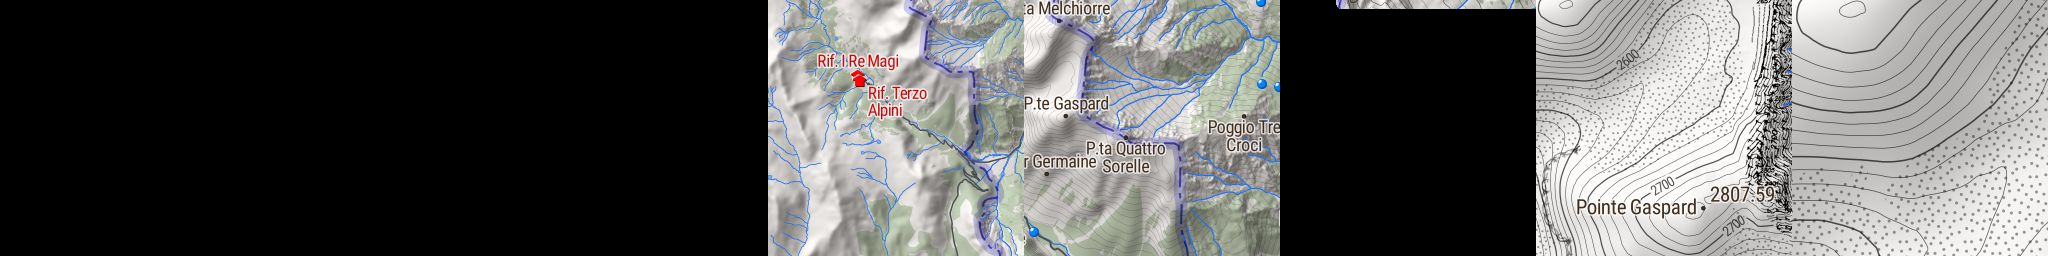

In [60]:
MY.tile_pyramid('/tmp/a.jpg', ll=T.LngLat(6.64, 45.08), mbt=finalpath)
display(Image('/tmp/a.jpg'))

In [66]:
!rm $finalpath
M.cut_to_lnglat(finalpath+'.bak', finalpath, bbfrit)

9 16 16
9 264 <> 267 328 <> 328
z 9 : 4
10 528 <> 534 656 <> 657
z 10 : 14
11 1056 <> 1068 1312 <> 1315
z 11 : 52
12 2112 <> 2137 2624 <> 2631
z 12 : 208
13 4224 <> 4275 5248 <> 5263
z 13 : 760
14 8448 <> 8551 10496 <> 10527
z 14 : 3040
15 16896 <> 17103 20992 <> 21055
z 15 : 12160
16 33792 <> 34207 41984 <> 42111
z 16 : 48599
real bounds: LngLatBbox(west=5.625000000000014, south=45.08903556483102, east=8.43749999999999, north=45.583289756006316)


# Annex - inspection

b'\xff\xd8\xff\xe0\x00\x10JFIF'


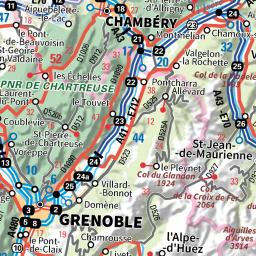

In [54]:
z, x, y, img = next(M.get_all_tiles(finalpath))
print(img[:10])
display(Image(img))

In [32]:
z, x, y, img = next(M.get_all_tiles(finalpath))


In [50]:
bb = M.get_bounds(finalpath)
bb

LngLatBbox(west=5.625, south=45.08904, east=8.4375, north=45.58329)

In [ ]:
from src.jpg_quality_pil_magick import get_jpg_quality

In [59]:
# why 45 kb/tile?
eps = 0.001
for lng, lat in ((bb.west+eps, bb.south+eps),(bb.west+eps, bb.north-eps),
                 (bb.east-1, bb.north-eps), (bb.east-1, bb.south+eps)):
    row = M.lnglat2tile(finalpath, z=16, lng=lng, lat=lat, what='*')
    if row:
        pim = Img.open(io.BytesIO(row[-1]))
        print(row[:-1], get_jpg_quality(pim))
    else:
        print('?')


(16, 33792, 41984) 99
(16, 33792, 42111) 99
(16, 34121, 42111) 99
(16, 34121, 41984) 99


*investigation of the jpeg quality too high was done on separate notebook jpg_debloat.ipynb*